## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split


# Preprocessing

In [4]:
## we will be removing all the stopwords from all the text file and stemming the text.

from nltk.corpus import stopwords
import nltk

stop_words = stopwords.words('english')
prt = nltk.stem.PorterStemmer()

def preprocess(document_path):
    
    with open(document_path, 'r') as file:
        document = file.read()
    
    tokens = nltk.word_tokenize(document)

    tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]

    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]

    terms = [prt.stem(i) for i in tokens_stop]
    
    return " ".join(terms)
import os
Data = []
for dirname, _, filenames in os.walk('./Dataset'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        
        doc_class = filename.split('_')[0].lower()
        doc_titles = filename
        documents = preprocess(os.path.join(dirname, filename))
        
        Data.append([doc_titles, documents, doc_class])

df = pd.DataFrame (Data, columns = ['Title', 'Document', 'Class'])


In [5]:
df

,Title,Document,Class
0,technologie_82.txt,game firm tough uk video game firm face test t...,technologie
1,technologie_96.txt,california set fine spywar maker comput progra...,technologie
2,technologie_41.txt,bet launch latest pocket offic 3g devic also w...,technologie
3,technologie_55.txt,oneplu 8 full spec comparison chart 8 8 pro 7 ...,technologie
4,technologie_69.txt,fear lost mobil peopl becom depend mobil phone...,technologie
...,...,...,...
995,graphics_38.txt,1pscti aqe srp stephen pietrowicz write go ori...,graphics
996,graphics_10.txt,hello everybodi use pixar renderman 3d scene d...,graphics
997,graphics_100.txt,need help creat 4x4 perspect matrix like use t...,graphics
998,graphics_11.txt,articl 1pp991 t63 jk87377 kouhia juhana write ...,graphics


In [97]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [98]:
token = tokenizer.encode_plus(
    df['Document'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [99]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  2236, 14516,  2047,  5088,  6477,  8517,  1669,  2112,
         1329,  6097,  1372,  2661,  5250, 18312,  1363,  2590,  6539,
         2367,  2304,  5991, 23662,  1182,  3869,  3073,  6906,  1964,
         5663,  2590,  6539,  2367,  2304,  1156,  1176,  1107,  1665,
         7535,  1181,  2112,  3952, 10632,  5837, 11252,   179,  1320,
         5837, 11252,  1328,  1267,   175, 22540,  5194,  2367,  2304,
         2311,  4956,  1372,  2373,  2371, 11613,  2311,  1893,  1596,
         1233,  2548,  6920,   175, 22540, 10857,  1818, 10116,  1268,
         2810, 13373,  1231,  2246,  7729, 14255,  2883,  1116,  1159,
          175, 22540,  2112, 28057,  1821,  1162,  2000,  9072, 11083,
         1363,  7584,  7317,  1182,  4392,  1282,  2590,  1549,  1553,
          172,  3161, 10182,  1233,  4056, 12862,  3644,  1231, 16481,
         1324,  1385,  2590,  1618,  3076,  1499,  1838,  1136,  1324,
         1260, 11135,  1231, 

In [100]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [101]:

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Document'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [102]:

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [103]:
labels = np.zeros((len(df), 10))
labels.shape

(1000, 10)

In [104]:
df['Class'] = pd.factorize(df['Class'])[0]
df

,Title,Document,Class
0,space_73.txt,date seri link messag period post usenet group...,0
1,space_33.txt,shag rob unverzagt write articl 5apr1993180450...,0
2,space_5.txt,anyon know size cold ga roll control thruster ...,0
3,space_8.txt,nanderso norman anderson write jmcocker mitch ...,0
4,space_66.txt,recent observ taken hubbl space telescop faint...,0
...,...,...,...
995,business_79.txt,us interest rate rise expect us interest rate ...,9
996,business_61.txt,hous price drop sale slow hous price fell nove...,9
997,business_52.txt,uk economi face uk manufactur sector continu f...,9
998,business_13.txt,industri reviv hope japan japanes industri gro...,9


In [105]:
labels[np.arange(len(df)), df['Class'].values.astype(int)] = 1

In [106]:

# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data
     

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [107]:

def ModelDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels
     

In [108]:
dataset = dataset.map(ModelDatasetMapFunction)

In [109]:

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [110]:


dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [111]:

p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train

In [112]:

train_size


49

In [113]:

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
     

# Creating Model

In [114]:

from transformers import TFBertModel

In [115]:

model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [116]:
from tensorflow.keras import regularizers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer', kernel_regularizer=regularizers.l2(0.01))(bert_embds)
drop_out = tf.keras.layers.Dropout(0.2, name="dropout")(intermediate_layer)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer', kernel_regularizer=regularizers.l2(0.01))(drop_out) # softmax -> calcs probs of classes

model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [117]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, decay_rate=1e-6, decay_steps=10000)

optim = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

loss_func = tf.keras.losses.CategoricalCrossentropy()

acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

model.compile(optimizer=optim, loss=loss_func, metrics=[acc, precision, recall])



In [118]:

hist =model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
49/49 [==============================] - 83s 939ms/step - loss: 8.6810 - accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 8.4610 - val_accuracy: 0.1731 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
49/49 [==============================] - 46s 946ms/step - loss: 8.1654 - accuracy: 0.3673 - precision: 0.9250 - recall: 0.0472 - val_loss: 7.4915 - val_accuracy: 0.7837 - val_precision: 0.9722 - val_recall: 0.1683
Epoch 3/5
49/49 [==============================] - 49s 999ms/step - loss: 7.2319 - accuracy: 0.7602 - precision: 0.9610 - recall: 0.3776 - val_loss: 6.8071 - val_accuracy: 0.9183 - val_precision: 0.9639 - val_recall: 0.7692
Epoch 4/5
49/49 [==============================] - 48s 989ms/step - loss: 6.7200 - accuracy: 0.9056 - precision: 0.9674 - recall: 0.7959 - val_loss: 6.5027 - val_accuracy: 0.9375 - val_precision: 0.9697 - val_recall: 0.9231
Epoch 5/5
49/49 [==============================] - 49s 999ms/step - loss: 6.5091 - accur

## Evaluation


In [119]:
model.evaluate(val_dataset)

13/13 [==============================] - 4s 303ms/step - loss: 6.3683 - accuracy: 0.9712 - precision: 0.9854 - recall: 0.9712


[6.368301868438721, 0.9711538553237915, 0.9853658676147461, 0.9711538553237915]

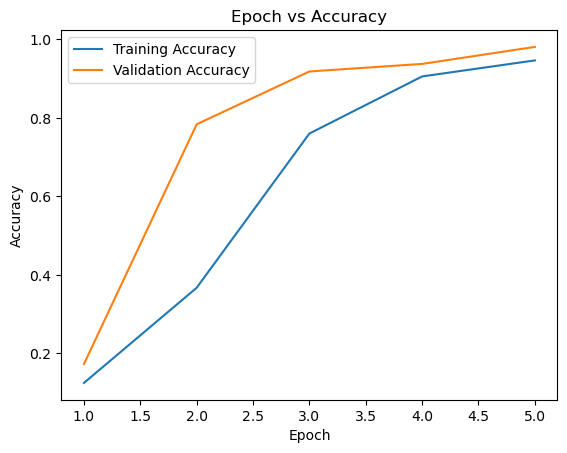

13/13 [==============================] - 4s 310ms/step - loss: 6.3801 - accuracy: 0.9712 - precision: 0.9804 - recall: 0.9615




loss is :  6.380051612854004
accuracy is:  97%
recall is:  96%
Precision is :  98%


In [120]:
import matplotlib.pyplot as plt
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot the epoch vs accuracy graph
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
loss,accuracy,precision,recall=model.evaluate(val_dataset)
print()
print()
print()
print()
print("loss is : ", loss)

print("accuracy is: ", str(round(accuracy*100))+ "%")
print("recall is: ", str(round(recall*100)) + "%")
print("Precision is : ", str(round(precision*100)) + "%")

In [121]:
model.save('model')

In [122]:

# model = tf.keras.models.load_model('model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['business', 'Entertainment', 'food', 'Graphichs', 'historical','medical','politcis', 'space','sport','technology']):
    probs = model.predict(processed_data)[0]
    return np.argmax(probs)
     

# Prediction

In [123]:
dict1 = {0:"Space", 1:"Politics",2:"Sport",3:"technology",4:"historical", 5:"Medical", 6:"Graphics",7:"Entertrainment",8:"Food",9:"business"}

In [124]:
text = """Bank voted 8-1 for no rate change

The decision to keep interest rates on hold at 4.75% earlier this month was passed 8-1 by the Bank of England's rate-setting body, minutes have shown.

One member of the Bank's Monetary Policy Committee (MPC) - Paul Tucker - voted to raise rates to 5%. The news surprised some analysts who had expected the latest minutes to show another unanimous decision. Worries over growth rates and consumer spending were behind the decision to freeze rates, the minutes showed. The Bank's latest inflation report, released last week, had noted that the main reason inflation might fall was weaker consumer spending.

However, MPC member Paul Tucker voted for a quarter point rise in interest rates to 5%. He argued that economic growth was picking up, and that the equity, credit and housing markets had been stronger than expected.

The Bank's minutes said that risks to the inflation forecast were "sufficiently to the downside" to keep rates on hold at its latest meeting. However, the minutes added: "Some members noted that an increase might be warranted in due course if the economy evolved in line with the central projection". Ross Walker, UK economist at Royal Bank of Scotland, said he was surprised that a dissenting vote had been made so soon. He said the minutes appeared to be "trying to get the market to focus on the possibility of a rise in rates". "If the economy pans out as they expect then they are probably going to have to hike rates." However, he added, any rate increase is not likely to happen until later this year, with MPC members likely to look for a more sustainable pick up in consumer spending before acting.
"""

In [125]:
input_text = text
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Predicted model: {result}")
     

1/1 [==============================] - 3s 3s/step
Predicted model: 9


In [126]:
output = dict1[result]

In [127]:
print(output)

business
